# English to French Translation 
## Seq2Seq (Encoder/Decoder) Model From Scratch

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html  


While recurrent nets allow us to process sequential data, things get tricky with *sequence length*. We can use an RNN (or variant) to process a sequence and convert that into a classification or regression (for example, language of origin for a name). We can even use a single RNN to learn to predict the next character in a sequence of text, allowing us to generate text.  
However, things break down when we want to predict a **sequence** of outputs, rather than a single/time-invariant output (like a class or a preceding character).  
This is where the encoder/decoder model comes in - one RNN is used to process the sequential data, producing a single output (the last hidden state at the end of its loop) which ideally encodes all the useful information about the sequence.  
Then a seperate RNN, the decoder, takes in the encoder's output and uses it to generate a sequence of output, with some other tricks lending a hand.  

### Encoder:  
I use a GRU as my recurrent component and additionally use an 'embedding layer' before the GRU. Thus the encoder receives a character, embeds the character, and passes the embedding and the hidden state into the GRU. The GRU uses the embedding and hidden state to update the hidden state. This repeats for every character in the sequence, and the final hidden state is the GRU's output.  

### Simple Decoder:  
The last output of the encoder (ie, last hidden state of the GRU) is also known as the 'context vector' since it has seen the entire input sequence. For a simple seq2seq model implementation we can just use this last vector as the initial hidden state for the GRU in the decoder component.  
The GRU also receives an input character - which to start is a special "start of phrase" token. Once again we can use a learnable embedding layer to embed this token before passing it into the GRU.  
For every input character, the decoder outputs an updated hidden state and a prediction of the next character. These get passed back into the GRU until it predicts the special "end of phrase" token.    

Finally, we backprop through the whole network and update its parameters.  




In [1]:
# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union
import numpy as np
import re


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D



# PyTorch
import torch
import torch.nn as nn

In [324]:
class TranslGRU:
    def __init__(self, input_size, 
                       enc_embed_dim, dec_embed_dim,
                       enc_hidden_size, dec_hidden_size, 
                       output_size
                ) -> None:
        """
        Define a GRU.
        input_size = number of elements in one-hot encoded vector for a single input.
        hidden_size = desired number of elements in the hidden and cell states
        output_size = None unless want a linear, dense layer ontop of the GRU converting last hidden state to logits of shape (output_size, 1)
        """
        self.input_size = input_size
        
        self.enc_embed_dim = enc_embed_dim
        self.dec_embed_dim = dec_embed_dim
        
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size

        self.output_size = output_size
        self.params = []

    def init_weights(self, lam=0.01, seed=123) -> None:
        """Initialize weight tensors for the model."""
        g = torch.Generator().manual_seed(seed)
        self._init_enc_weights(lam=lam, g=g)
        self._init_dec_weights(lam=lam, g=g)
        
        for p in self.params:
            p.requires_grad = True 
        self.n_parameters = self._count_params()

    def init_hidden(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.hidden_size, 1))  #(hidden size , batch size)
        return hidden


    def _init_enc_weights(self, g, lam=0.01, ) -> None:
        """Initialize weight tensors for the decoder model."""
        concat_size = self.enc_embed_dim + self.enc_hidden_size

        self.enc_embed = torch.rand((self.input_size, self.enc_embed_dim), generator=g) * lam

        self.enc_W_reset = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        self.enc_br = torch.zeros((self.enc_hidden_size, 1)) * lam
        self.enc_W_update = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        self.enc_bu = torch.zeros((self.enc_hidden_size, 1)) * lam
        self.enc_W_htilde = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        self.params += [self.enc_embed, self.enc_W_reset, self.enc_br, self.enc_W_update, self.enc_bu, self.enc_W_htilde]
    
    def _init_dec_weights(self, g, lam=0.01) -> None:
        """Initialize weight tensors for the encoder."""
        concat_size = self.dec_embed_dim + self.dec_hidden_size

        self.dec_embed = torch.rand((self.input_size, self.dec_embed_dim), generator=g) * lam

        self.dec_W_reset = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        self.dec_br = torch.zeros((self.dec_hidden_size, 1)) * lam
        self.dec_W_update = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        self.dec_bu = torch.zeros((self.dec_hidden_size, 1)) * lam
        self.dec_W_htilde = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        # FC
        self.W_h2o = torch.rand((self.output_size, self.dec_hidden_size), generator=g) * lam
        self.b_h20 = torch.zeros((self.output_size, 1)) * lam
        self.params += [self.dec_embed, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde, self.W_h2o, self.b_h20]
   

    def encoder(self, hidden_prev, x_tensor_t,):
        "ENCODER AT STEP T"
        input = self.enc_embed[x_tensor_t]
        hidden_new = self.gru(input, hidden_prev)
        return hidden_new
    
    def simple_decoder(self, context_vector, input_char_t):
        "DECODER AT STEP T"
        input = self.dec_embed[input_char_t]
        hidden_new = self.gru(input, context_vector)
        
        # run hidden state through linear softmax layer to predict next char
        output = self.linear_softmax(hidden_new)
        next_input_char = torch.argmax(output, dim=1)
        return next_input_char, hidden_new

    
    def gru(self, input, hidden) -> torch.tensor:
        """One forward step in a GRU cell to update hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(self.W_reset @ concat_raw + self.br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(self.W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(self.W_update @ concat_raw + self.bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    
    def linear_softmax(self, input):
        return torch.softmax( (self.W_h2o @ input) + self.b_h20 )


    def backprop_update(self, lr) -> None:
        
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i) ##silly debugging
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

In [ ]:
def forward(x, y=None, hidden=None, truncate=None):
    """
    Perform an entire forward pass of a sample to calculate outputs and calculate loss if y is provided.
    Returns logits, loss.
    """
    # Initialize states with zeroes
    if hidden is None:
        hidden = self.init_states()
    
    
    # Pass through X sequentially and index embedding by current character
    # Pass character embedding and previous hidden state to GRU
    loss = 0
    for t in range(x.shape[0]):
        model.encoder(hidden, )

        # If output shape is not equal to hidden shape, pass through a linear layer to calculate final logits
        if self.output_size is not None:
            logits = (self.W_h2o @ hidden) + self.b_h20
        else:
            logits = hidden
        full_logits[t] = logits.squeeze()
    
        # Calculate loss 
        if y is not None:
            y_size = self.output_size if self.output_size is not None else self.hidden_size
            y_ohe = torch.zeros(y_size)
            y_ohe[y[t]] = 1.0
            loss += torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)

            # if x.shape[0]-t == truncate:
            #     loss.backward()
            #     loss.detach()

    self.loss = loss

    return full_logits, loss


In [30]:
def words_to_data(english, french, stoi, special_char:str):
    """
    Takes words list and breaks into training samples such that
    block_size characters are used to predict the following character.
    Returns X, Y (inputs and labels), where each sample in X is a tensor containing block_size elements
    and each sample in Y is a tensor containing one element.
    """

    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for en, fr in zip(english, french):
        
        diff = len(fr) - len(en)
        if diff > 0:
            add_to_en = abs(diff)
            add_to_fr = 0
        elif diff < 0:
            add_to_en = 0
            add_to_fr = abs(diff)
        else:
            add_to_en = 0
            add_to_fr = 0

        english_ix, french_ix = [], []
        for ch in en:
            english_ix.append(stoi[ch])
        english_ix.append(stoi[special_char])
        english_ix += [stoi[special_char]] * add_to_en

        for ch in fr:
            french_ix.append(stoi[ch])
        french_ix.append(stoi[special_char])
        french_ix += [stoi[special_char]] * add_to_fr

        X.append(torch.tensor(english_ix))
        Y.append(torch.tensor(french_ix))
    # X = torch.tensor(X)
    # Y = torch.tensor(Y)
    # n_samples = X.shape[0]
    # print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [4]:
MAX_FR_CHRS = 100
english, french = [],[]

matches = ["(", "‽", "…", "€"]
with open("./data/rnn_tut_data/eng-fra.txt", encoding="utf-8") as file:
    for line in file:
        line = line.rstrip()
        line = line.replace(u"\u202f", " ")
        line = line.replace(u"\u3000", " ")
        line = line.replace(u"\u2000", " ")
        line = line.replace(u"\u200b", " ")
        line = line.replace(u"\xa0", " ")
        line = line.replace(u"\xad", " ")
        line = line.replace(u"\u2009", " ")
        line = line.replace("ú", "u")
        line = line.replace("–", "-")
        line = line.replace("а", "a")
        line = line.replace("‐", "-")
        if any(s in line for s in matches): ##removes some edge cases
            pass
        else:        
            eng, fra = line.split('\t')
        
        if (len(fra)>MAX_FR_CHRS):
            pass
        else:
            english.append(eng)
            french.append(fra)

In [5]:
print(len(english))
print(len(french))

eng_chars = set(''.join(english))
fra_chars = set(''.join(french))
all_chars = set(''.join(english + french))
print(len(eng_chars))
print(len(fra_chars))
print(len(all_chars))

print("max french length = ", len(max(french, key=len)), "chars")

135332
135332
83
104
104
max french length =  100 chars


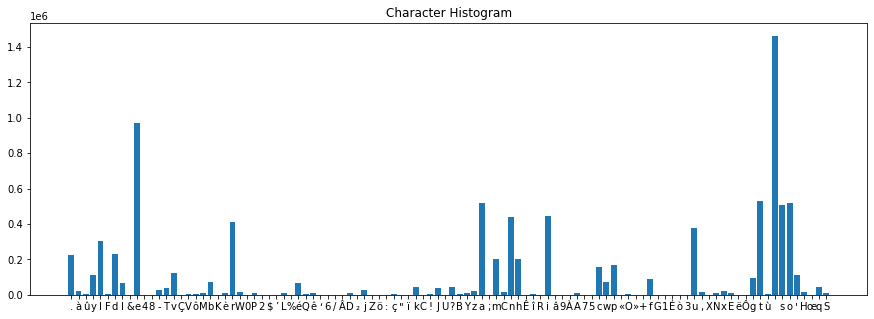

In [6]:
stoi = {s:i+1 for i, s in enumerate(all_chars)} ##create dictionary mapping from char to int
stoi['*'] = 0 #special char
itos = {i:s for s, i in stoi.items()}


corpus = ''.join(english+french)
count_letters = dict()

for c in all_chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

# Train

In [325]:
samples = 300
xs, ys = words_to_data(english[:samples], french[:samples], stoi, special_char="*")

n_letters = len(stoi)
hidden_size = 64
emb_dim = 33

model = TranslGRU(input_size=n_letters,
                  enc_embed_dim=emb_dim,
                  dec_embed_dim=emb_dim,
                  enc_hidden_size=hidden_size,
                  dec_hidden_size=hidden_size,                  
                  output_size=n_letters)
model.init_weights(lam=0.01)

print(model.n_parameters)

51259


In [311]:
for _ in range(1000):
    s_ix = 200 #random.randint(0, len(x)-1)

    x_i, y_i = xs[s_ix], ys[s_ix]
    # x_ohe = torch.nn.functional.one_hot(x_i, n_letters)
    # x_ohe = torch.unsqueeze(x_ohe, dim=1) #insert 'batch' dim

    logits, loss = model.forward(x_i, y_i)

    model.backprop_update(lr=0.1)
print(loss)

tensor(0.0248, grad_fn=<AddBackward0>)


In [313]:
phrase = []
truth = []
for i in range(logits.shape[0]):
    indx = torch.argmax(logits[0]).item()
    phrase.append(itos[indx])
    truth.append(itos[y_i[i].item()])

print("".join(phrase)) 
print("".join(truth))

AAAAAAAAAAAAA
Appelle Tom.*


In [38]:
logs = torch.zeros((n_letters, 3))
logs[:, 0] = logits.squeeze()

In [ ]:
torch.nn.functional.softmax(logits, dim=0)